In [191]:
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from evaluation import smape
from matplotlib import pyplot
import numpy as np
import os

# Sepcify k to select a specific csv file in the station_data folder
k = 34
station_file = 'C:\\Users\\Juliana\\Desktop\\msbd5002project_group6\\station_data'

def euclidean_distance(x,y):
    return np.linalg.norm(x-y)

df_air_info = pd.read_csv('Air_Station_ID.csv')
df_grid_info = pd.read_csv('Beijing_grid_weather_station.csv')

no_air = df_air_info['stationId'].count()
no_grid = df_grid_info['gridId'].count()

air_join_grid = []
for i in range(no_air):
    temp = []
    air_geo = np.array([df_air_info['long'].iloc[i],df_air_info['lat'].iloc[i]])
    for j in range(no_grid):
        grid_geo = np.array([df_grid_info['long'].iloc[j],df_grid_info['lat'].iloc[j]])
        distance = euclidean_distance(air_geo,grid_geo)
        temp.append([df_grid_info['gridId'].iloc[j],distance])
    nearest_index = np.argmin(np.array(temp),axis = 0)[1]
    air_join_grid.append([df_air_info['stationId'].iloc[i], df_grid_info['gridId'].iloc[nearest_index]])

df_station = pd.read_csv(os.path.join(station_file,air_join_grid[k][0]) + ".csv", index_col=1)
df_station.drop(['stationId'],axis = 1,inplace = True)

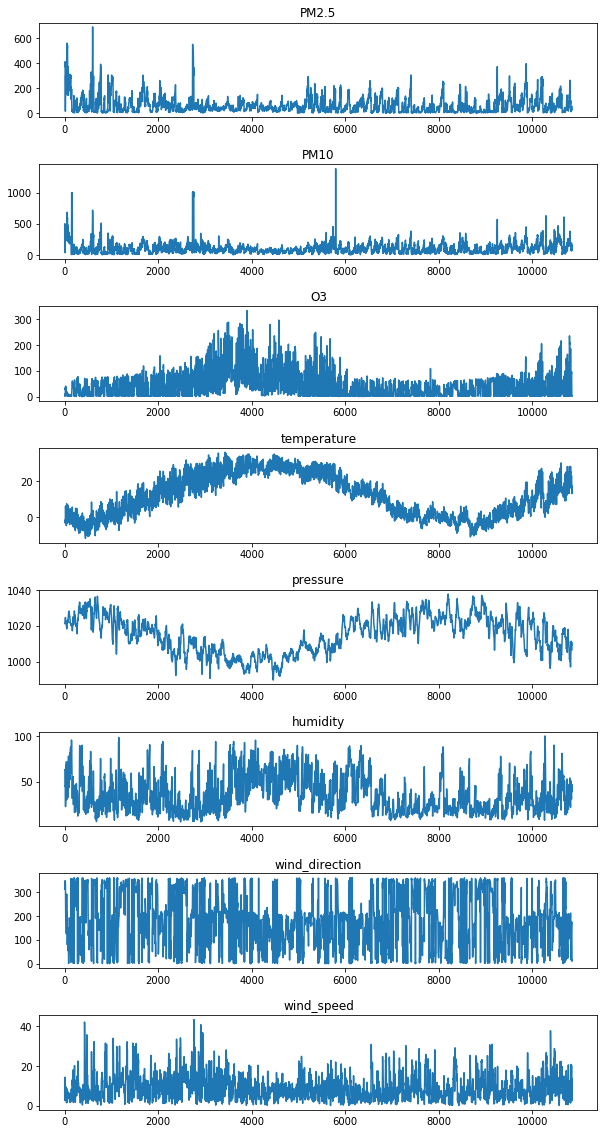

In [3]:
from matplotlib import pyplot
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(8, 1, hspace = 0.5)
# load dataset
values = df_station.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 0
# plot each column
pyplot.figure(figsize=(10,20))
for group in groups:
    pyplot.subplot(gs[i,0])
    pyplot.plot(values[:, group])
    pyplot.title(df_station.columns[group])
    i += 1
pyplot.show()

Train on 5425 samples, validate on 5425 samples
Epoch 1/50
 - 1s - loss: 0.0578 - val_loss: 0.0439
Epoch 2/50
 - 0s - loss: 0.0374 - val_loss: 0.0325
Epoch 3/50
 - 0s - loss: 0.0292 - val_loss: 0.0326
Epoch 4/50
 - 0s - loss: 0.0264 - val_loss: 0.0291
Epoch 5/50
 - 0s - loss: 0.0245 - val_loss: 0.0259
Epoch 6/50
 - 0s - loss: 0.0232 - val_loss: 0.0250
Epoch 7/50
 - 0s - loss: 0.0227 - val_loss: 0.0241
Epoch 8/50
 - 0s - loss: 0.0222 - val_loss: 0.0234
Epoch 9/50
 - 0s - loss: 0.0217 - val_loss: 0.0231
Epoch 10/50
 - 0s - loss: 0.0211 - val_loss: 0.0227
Epoch 11/50
 - 0s - loss: 0.0206 - val_loss: 0.0216
Epoch 12/50
 - 0s - loss: 0.0202 - val_loss: 0.0208
Epoch 13/50
 - 0s - loss: 0.0197 - val_loss: 0.0204
Epoch 14/50
 - 0s - loss: 0.0193 - val_loss: 0.0200
Epoch 15/50
 - 0s - loss: 0.0193 - val_loss: 0.0193
Epoch 16/50
 - 0s - loss: 0.0191 - val_loss: 0.0188
Epoch 17/50
 - 0s - loss: 0.0189 - val_loss: 0.0188
Epoch 18/50
 - 0s - loss: 0.0190 - val_loss: 0.0192
Epoch 19/50
 - 0s - loss:

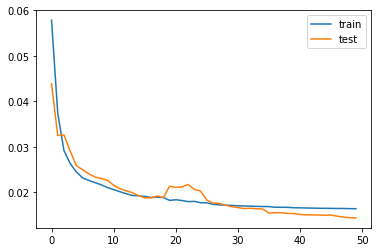

Test RMSE: 22.601
SMAPE : 0.348


In [193]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense
from keras.layers import LSTM
from evaluation import smape

learning_rate_function = ReduceLROnPlateau(monitor='val_loss',patience = 3, verbose = 1, factor = 0.7, min_lr = 0.00001)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

lookback = 2
values = df_station.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, lookback, 1)
reframed.drop(reframed.columns[[lookback*8+3,lookback*8+4,lookback*8+5,lookback*8+6,lookback*8+7]], axis=1, inplace=True)

values = reframed.values
n_train_hours = 5425
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-3], train[:,range(-3,0)]
test_X, test_y = test[:, :-3], test[:, range(-3,0)]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(lookback*50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[learning_rate_function])
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, (lookback-1)*8 + 3:lookback*8]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:3]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 3))
inv_y = concatenate((test_y, test_X[:, (lookback-1)*8 + 3:lookback*8]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:3]
# calculate RMSE
smape = smape(inv_y,inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('SMAPE : %.3f' % smape)

### Prediction & Evaluation

In [140]:
import pandas as pd

df_prev = df_station.tail(lookback)
df_predict = pd.read_csv('gridWeather_20180501-20180502.csv')
df_predict = df_predict[df_predict['station_id'] == air_join_grid[k][1]]
df_predict.drop(['id','weather','station_id'], axis = 1, inplace = True)

length = df_predict['time'].count()
df_predict =df_predict.set_index('time')
df_predict['PM2.5'] = [0]*length
df_predict['PM10'] = [0]*length
df_predict['O3'] = [0]*length
df_predict = df_predict[['PM2.5','PM10','O3','temperature','pressure','humidity','wind_direction','wind_speed']]

df = pd.concat([df_prev, df_predict])

scaled_pred = scaler.fit_transform(df.values)
reframed_pred = series_to_supervised(scaled_pred, lookback, 1)

for i in range(48):
    x = reframed_pred.iloc[i][:8*lookback+3].values
    x = x.astype('float32')
    x = x.reshape((1,1,x.shape[0]))
    x = x[:,:,:-3]
    x_1 = model.predict(x)
    for j in range(lookback+1):
        if i + j < 48:
            reframed_pred.iloc[[i+j],[8*(lookback-j)]] = x_1[0][0]
            reframed_pred.iloc[[i+j],[8*(lookback-j)+1]] = x_1[0][1]
            reframed_pred.iloc[[i+j],[8*(lookback-j)+2]] = x_1[0][2]
            

final_pred = reframed_pred[reframed_pred.columns[[*range(lookback*8,lookback*8+8)]]]

for i in range(48):
    x = final_pred.iloc[i].values
    x = x.reshape((1,x.shape[0]))
    x = scaler.inverse_transform(x)
    #x = np.array([int(x[0][0]),int(x[0][1]),int(x[0][2]),x[0][3],x[0][4],x[0][5],x[0][6],x[0][7]])
    df.iloc[[i+lookback],[0]] = max(int(x[0][0]),0)
    df.iloc[[i+lookback],[1]] = max(int(x[0][1]),0)
    df.iloc[[i+lookback],[2]] = max(int(x[0][2]),0)
    
df['station_id'] = [air_join_grid[k][0]]*(48+lookback)
df['time'] = df.index

df = df[['time','station_id','PM2.5', 'PM10', 'O3', 'temperature', 'pressure', 'humidity','wind_direction','wind_speed']]

df = df.rename(index=str, columns={"PM2.5": "PM2.5(t)", "PM10": "PM10(t)","O3": "O3(t)"})

storing_path = "C:/Users/Juliana/Desktop/msbd5002project_group6/prediction[LSTM_model]/"
if not os.path.exists(storing_path):
    os.makedirs(storing_path)

#This save the prediction for the specific station. Specific k for the prediction output saving in the custom directory
#df.to_csv(os.path.join(storing_path,air_join_grid[k][0]) + '.csv', index = False)

## Visualizing the prediction result

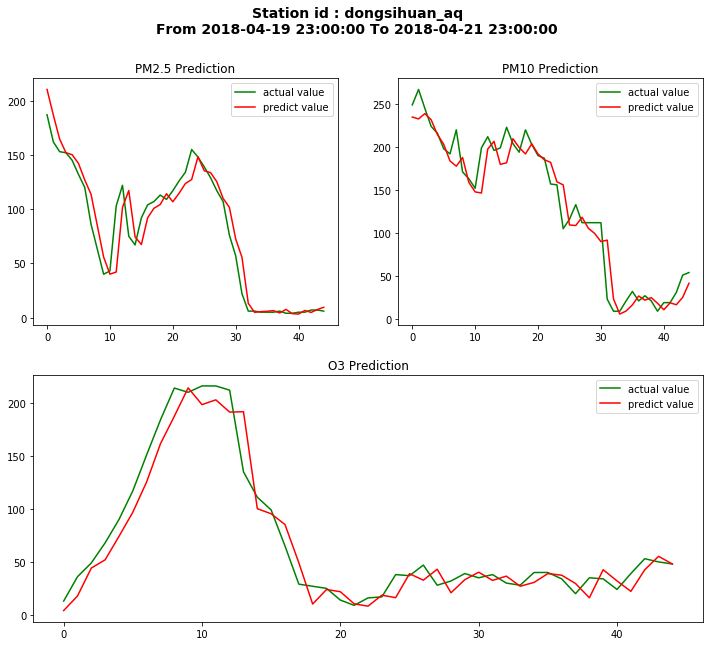

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

start_time_str = '2018-04-19 23:00:00'
end_time_str = '2018-04-21 23:00:00'

for j, date in enumerate(df_station.index.values):
    if date == start_time_str:
        start_index = j - lookback
    if date == end_time_str:
        end_index = j - lookback

actual = inv_y[(start_index-n_train_hours):(end_index-n_train_hours)]
predict = inv_yhat[(start_index-n_train_hours):(end_index-n_train_hours)]

length = actual.shape[0]

gs = gridspec.GridSpec(2, 2, hspace = 0.2)
fig = plt.figure(figsize=(12,10))
fig.suptitle('Station id : ' + air_join_grid[k][0] + '\nFrom ' + start_time_str + ' To ' + end_time_str,
             fontsize=14, fontweight='bold')
plt.subplot(gs[0,0])
plt.plot([*range(length)], actual[:,0], color='g', label='actual value')
plt.plot([*range(length)], predict[:,0], color='r', label='predict value')
plt.title('PM2.5 Prediction')
plt.legend()

plt.subplot(gs[0,1])
plt.plot([*range(length)], actual[:,1], color='g', label='actual value')
plt.plot([*range(length)], predict[:,1], color='r', label='predict value')
plt.title('PM10 Prediction')
plt.legend()

plt.subplot(gs[1,:])
plt.plot([*range(length)], actual[:,2], color='g', label='actual value')
plt.plot([*range(length)], predict[:,2], color='r', label='predict value')
plt.title('O3 Prediction')
plt.legend()
#df_actual

In [143]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 47,103
Trainable params: 47,103
Non-trainable params: 0
_________________________________________________________________


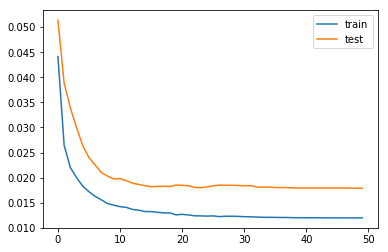

0
Station Name: dongsi_aq
Test RMSE: 25.724
SMAPE : 0.245


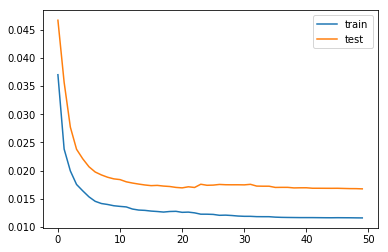

1
Station Name: tiantan_aq
Test RMSE: 24.796
SMAPE : 0.265


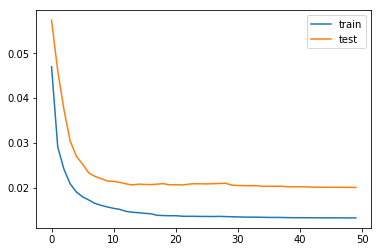

2
Station Name: guanyuan_aq
Test RMSE: 26.236
SMAPE : 0.269


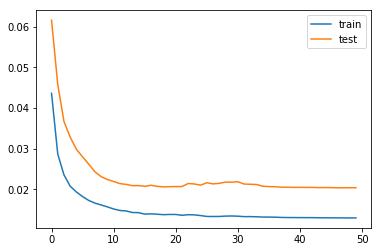

3
Station Name: wanshouxigong_aq
Test RMSE: 27.835
SMAPE : 0.274


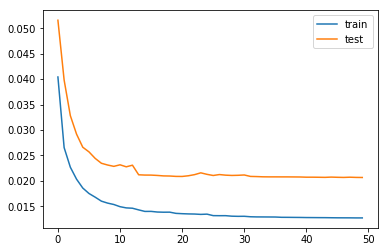

4
Station Name: aotizhongxin_aq
Test RMSE: 24.664
SMAPE : 0.262


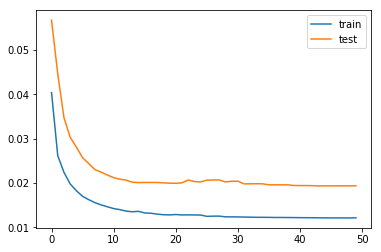

5
Station Name: nongzhanguan_aq
Test RMSE: 25.851
SMAPE : 0.256


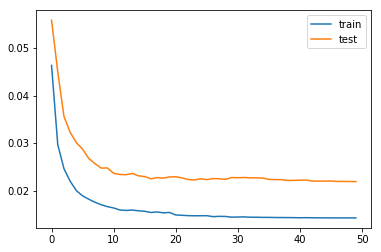

6
Station Name: wanliu_aq
Test RMSE: 25.076
SMAPE : 0.280


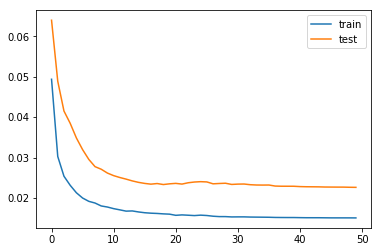

7
Station Name: beibuxinqu_aq
Test RMSE: 30.725
SMAPE : 0.278


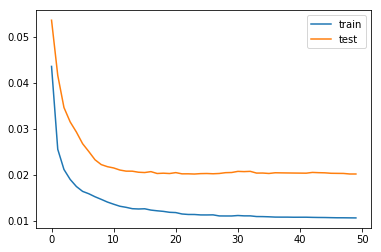

8
Station Name: zhiwuyuan_aq
Test RMSE: 26.052
SMAPE : 0.264


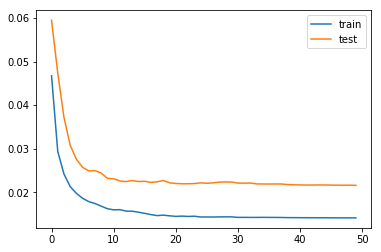

9
Station Name: fengtaihuayuan_aq
Test RMSE: 25.913
SMAPE : 0.300


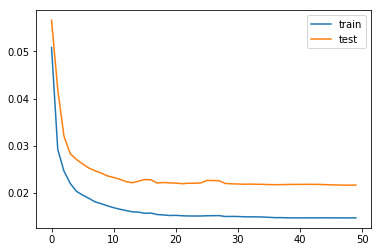

10
Station Name: yungang_aq
Test RMSE: 27.467
SMAPE : 0.245


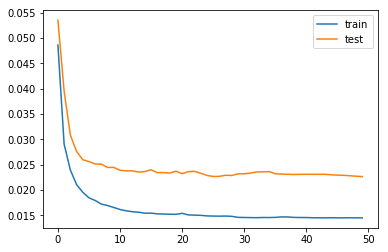

11
Station Name: gucheng_aq
Test RMSE: 28.683
SMAPE : 0.276


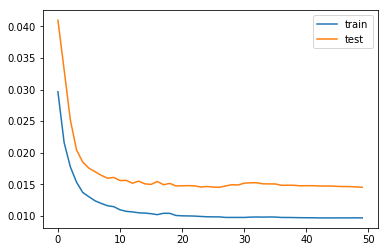

12
Station Name: fangshan_aq
Test RMSE: 39.554
SMAPE : 0.287


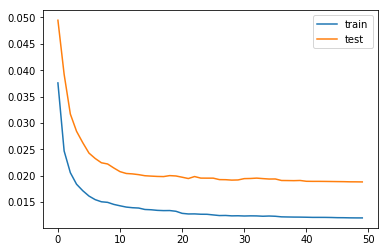

13
Station Name: daxing_aq
Test RMSE: 30.472
SMAPE : 0.274


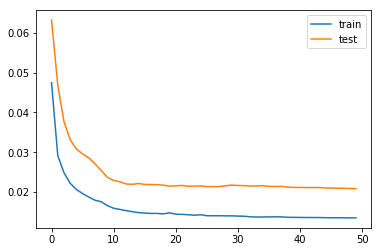

14
Station Name: yizhuang_aq
Test RMSE: 26.800
SMAPE : 0.250


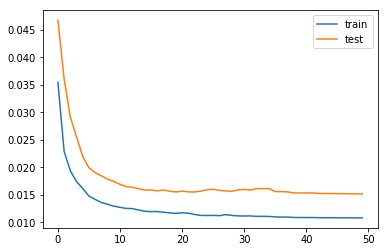

15
Station Name: tongzhou_aq
Test RMSE: 27.391
SMAPE : 0.270


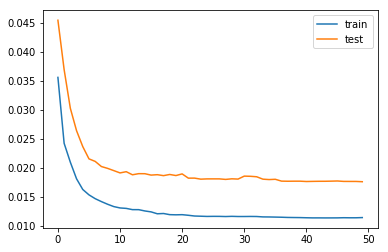

16
Station Name: shunyi_aq
Test RMSE: 29.396
SMAPE : 0.280


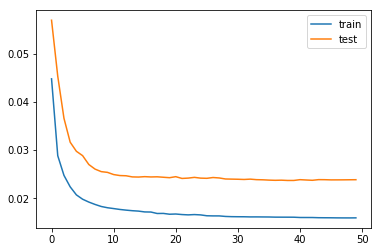

17
Station Name: pingchang_aq
Test RMSE: 28.418
SMAPE : 0.286


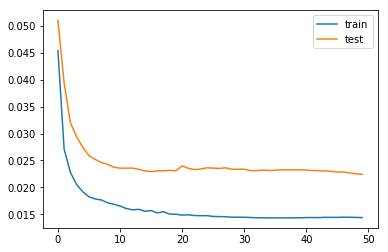

18
Station Name: mentougou_aq
Test RMSE: 28.384
SMAPE : 0.255


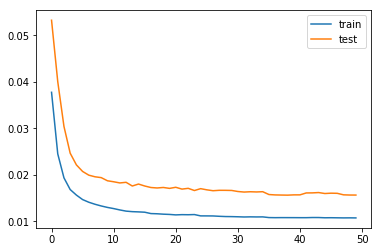

19
Station Name: pinggu_aq
Test RMSE: 26.875
SMAPE : 0.264


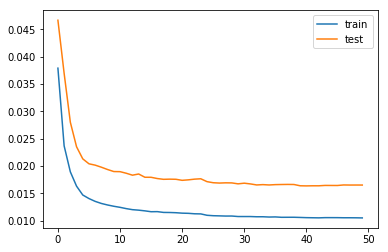

20
Station Name: huairou_aq
Test RMSE: 39.926
SMAPE : 0.271


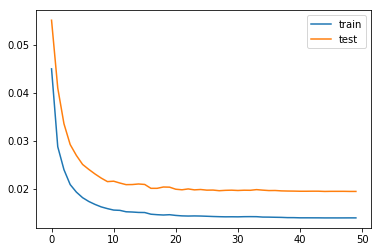

21
Station Name: miyun_aq
Test RMSE: 25.645
SMAPE : 0.279


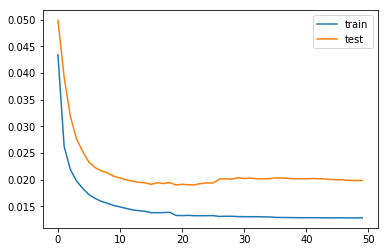

22
Station Name: yanqin_aq
Test RMSE: 29.248
SMAPE : 0.283


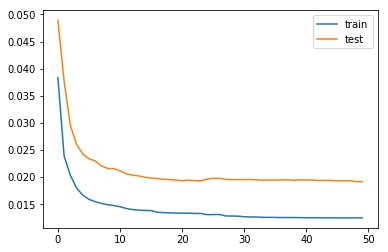

23
Station Name: dingling_aq
Test RMSE: 29.677
SMAPE : 0.232


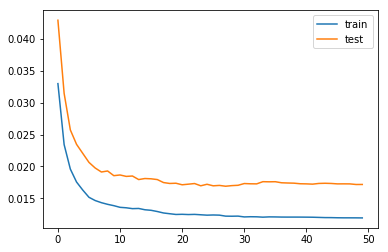

24
Station Name: badaling_aq
Test RMSE: 30.114
SMAPE : 0.289


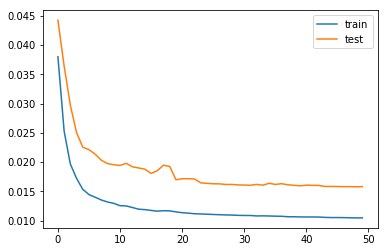

25
Station Name: miyunshuiku_aq
Test RMSE: 27.195
SMAPE : 0.271


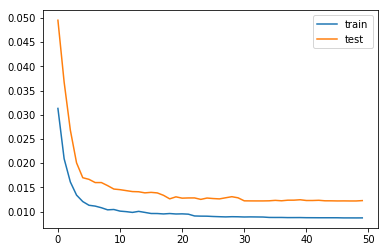

26
Station Name: donggaocun_aq
Test RMSE: 27.529
SMAPE : 0.262


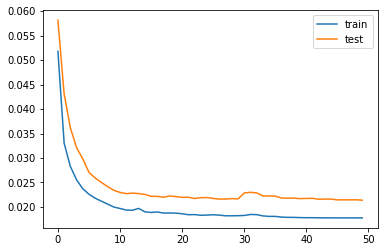

27
Station Name: yongledian_aq
Test RMSE: 27.408
SMAPE : 0.286


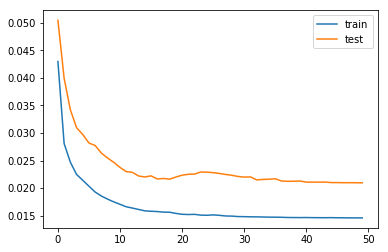

28
Station Name: yufa_aq
Test RMSE: 35.685
SMAPE : 0.285


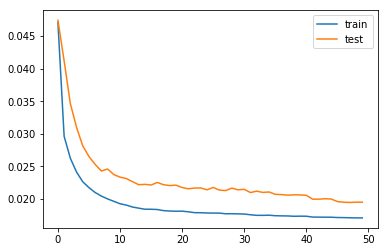

29
Station Name: liulihe_aq
Test RMSE: 34.140
SMAPE : 0.311


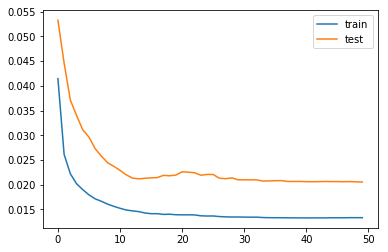

30
Station Name: qianmen_aq
Test RMSE: 25.589
SMAPE : 0.269


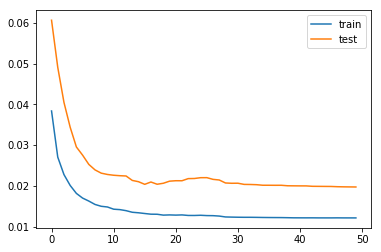

31
Station Name: yongdingmennei_aq
Test RMSE: 27.776
SMAPE : 0.259


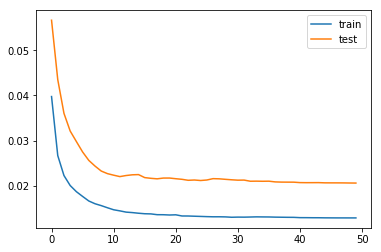

32
Station Name: xizhimenbei_aq
Test RMSE: 25.465
SMAPE : 0.250


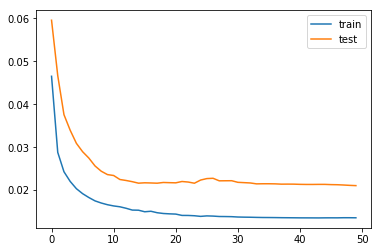

33
Station Name: nansanhuan_aq
Test RMSE: 26.673
SMAPE : 0.248


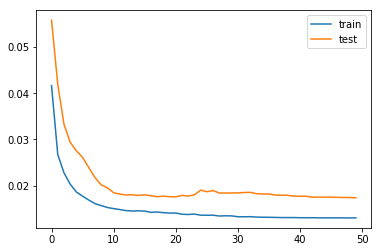

34
Station Name: dongsihuan_aq
Test RMSE: 23.051
SMAPE : 0.241


In [2]:
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from evaluation import smape
from matplotlib import pyplot
import numpy as np
import os

station_file = 'C:\\Users\\Juliana\\Desktop\\msbd5002project_group6\\station_data'

def euclidean_distance(x,y):
    return np.linalg.norm(x-y)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

df_air_info = pd.read_csv('Air_Station_ID.csv')
df_grid_info = pd.read_csv('Beijing_grid_weather_station.csv')

no_air = df_air_info['stationId'].count()
no_grid = df_grid_info['gridId'].count()

air_join_grid = []
for i in range(no_air):
    temp = []
    air_geo = np.array([df_air_info['long'].iloc[i],df_air_info['lat'].iloc[i]])
    for j in range(no_grid):
        grid_geo = np.array([df_grid_info['long'].iloc[j],df_grid_info['lat'].iloc[j]])
        distance = euclidean_distance(air_geo,grid_geo)
        temp.append([df_grid_info['gridId'].iloc[j],distance])
    nearest_index = np.argmin(np.array(temp),axis = 0)[1]
    air_join_grid.append([df_air_info['stationId'].iloc[i], df_grid_info['gridId'].iloc[nearest_index]])

for k in range(35):
    df_station = pd.read_csv(os.path.join(station_file,air_join_grid[k][0]) + ".csv", index_col=1)
    df_station.drop(['stationId'],axis = 1,inplace = True)
    learning_rate_function = ReduceLROnPlateau(monitor='val_loss',patience = 3, verbose = 0, factor = 0.7, min_lr = 0.00001)

    lookback = 2
    values = df_station.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    reframed = series_to_supervised(scaled, lookback, 1)
    reframed.drop(reframed.columns[[lookback*8+3,lookback*8+4,lookback*8+5,lookback*8+6,lookback*8+7]], axis=1, inplace=True)

    values = reframed.values
    n_train_hours = 5425
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    train_X, train_y = train[:, :-3], train[:,range(-3,0)]
    test_X, test_y = test[:, :-3], test[:, range(-3,0)]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    model = Sequential()
    model.add(LSTM(lookback*50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(3))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=0, shuffle=False, callbacks=[learning_rate_function])
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, (lookback-1)*8 + 3:lookback*8]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0:3]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 3))
    inv_y = concatenate((test_y, test_X[:, (lookback-1)*8 + 3:lookback*8]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0:3]
    # calculate RMSE
    smape_score = smape(inv_y,inv_yhat)
    rmse_score = sqrt(mean_squared_error(inv_y, inv_yhat))
    print(k)
    print('Station Name: ' + air_join_grid[k][0])
    print('Test RMSE: %.3f' % rmse_score)
    print('SMAPE : %.3f' % smape_score)
    
    del smape_score
    del rmse_score
    del inv_y
    del inv_yhat
    del df_station
    

## Concatenate all output csv files in the prediction folder 

In [3]:
import os
import pandas as pd
from datetime import datetime

storing_path = "C:/Users/Juliana/Desktop/msbd5002project_group6/prediction[LSTM_model]/"
file = os.listdir(storing_path)

for i,f in enumerate(file):
    if i == 0:
        df = pd.read_csv(os.path.join(storing_path,f))
        df = df[df['time'] > '2018-04-30 23:00:00']
    else:
        df_temp = pd.read_csv(os.path.join(storing_path,f))
        df_temp = df_temp[df_temp['time'] > '2018-04-30 23:00:00']
        df = pd.concat([df,df_temp],sort = True)

df.reset_index(drop=True, inplace=True)
df = df[['station_id','time','PM2.5(t)','PM10(t)','O3(t)']]

length = df['station_id'].count()

df = df.rename(index=str, columns={"PM2.5(t)": "PM2.5", "PM10(t)": "PM10","O3(t)": "O3"})
df['test_id'] = df['station_id']

for j in range(length):
    date_j = datetime.strptime(df['time'].iloc[j],"%Y-%m-%d %H:%M:%S")
    if date_j.day == 1:
        df['test_id'].iloc[j] = df['station_id'].iloc[j] + "#" + str(date_j.hour)
    else:
        df['test_id'].iloc[j] = df['station_id'].iloc[j] + "#" + str(date_j.hour  + 24)

df = df[['test_id','PM2.5','PM10','O3']]
df.to_csv('LSTM Model Prediction Result.csv', index = False)

C:\Users\Juliana\Anaconda2\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
